In [50]:
# import packages
from arch import arch_model
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
import warnings
from tqdm import tqdm 
from time import sleep
%matplotlib inline

In [3]:
# read dataframe from covid_explore.ipynb output
covid = pd.read_csv("./data/covid/covid19_20210104_mod.csv", index_col='date', parse_dates=True)

In [20]:
covid.head()

,days_elapse,new_count_update,new_deaths_update,new_recover_update,new_numtotal,new_numdeaths,new_numrecover
date,,,,,,,
2020-01-31,0,1.0,0.0,0.0,1.0,0.0,0.0
2020-02-01,1,0.0,0.0,0.0,1.0,0.0,0.0
2020-02-02,2,0.0,0.0,0.0,1.0,0.0,0.0
2020-02-03,3,0.0,0.0,0.0,1.0,0.0,0.0
2020-02-04,4,0.0,0.0,0.0,1.0,0.0,0.0


In [64]:
# select columns of interest and remove all dates up to March 1
# from the start of the pandemic in BC
covid_mod = covid.loc['2020-07-01':,('days_elapse', 'new_count_update')].copy()
#covid_mod.reset_index(inplace=True, drop=True)
covid_mod.columns = ['days_elapse', 'daily_case']

# add a 3, 5, 7 and 14-day rolling mean
# also add a 14-day rolling std-dev in the event a 14-day standardization is used
covid_mod['daily_case_3mean'] = covid_mod['daily_case'].rolling(window = 3).mean()
covid_mod['daily_case_5mean'] = covid_mod['daily_case'].rolling(window = 5).mean()
covid_mod['daily_case_7mean'] = covid_mod['daily_case'].rolling(window = 7).mean()
covid_mod['daily_case_14mean'] = covid_mod['daily_case'].rolling(window = 14).mean()
covid_mod['daily_case_14stdev'] = covid_mod['daily_case'].rolling(window = 14).std()

In [65]:
covid_mod.head(20)

,days_elapse,daily_case,daily_case_3mean,daily_case_5mean,daily_case_7mean,daily_case_14mean,daily_case_14stdev
date,,,,,,,
2020-07-01,152,12.0,NaN,NaN,NaN,NaN,NaN
2020-07-02,153,12.0,NaN,NaN,NaN,NaN,NaN
2020-07-03,154,7.0,10.333333,NaN,NaN,NaN,NaN
2020-07-04,155,10.0,9.666667,NaN,NaN,NaN,NaN
2020-07-05,156,10.0,9.000000,10.2,NaN,NaN,NaN
2020-07-06,157,11.0,10.333333,10.0,NaN,NaN,NaN
2020-07-07,158,12.0,11.000000,10.0,10.571429,NaN,NaN
2020-07-08,159,18.0,13.666667,12.2,11.428571,NaN,NaN
2020-07-09,160,20.0,16.666667,14.2,12.571429,NaN,NaN


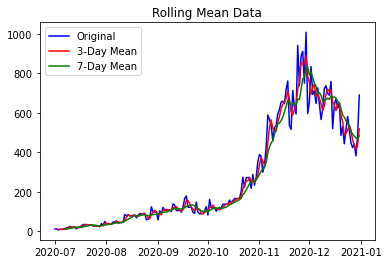

In [66]:
# compare the 3-day mean with the original dataset to check it makes sense
plt.plot(covid_mod.index, covid_mod['daily_case'], color = 'blue', label = 'Original')
plt.plot(covid_mod.index, covid_mod['daily_case_3mean'], color = 'red', label = '3-Day Mean')
plt.plot(covid_mod.index, covid_mod['daily_case_7mean'], color = 'green', label = '7-Day Mean')
plt.legend(loc = 'best')
plt.title('Rolling Mean Data')
plt.show()

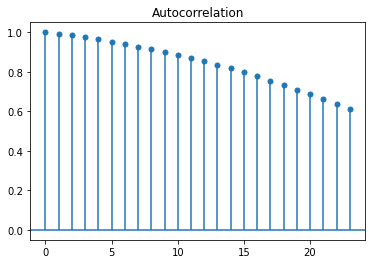

In [67]:
pm.plot_acf(covid_mod['daily_case_5mean'].dropna())

In [68]:
pm.arima.ndiffs(covid_mod['daily_case_7mean'].dropna(), max_d=5)

1

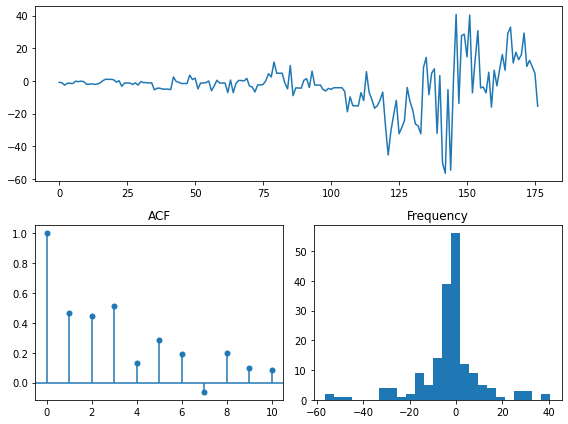

In [69]:
pm.tsdisplay((covid_mod['daily_case_7mean'].shift()-covid_mod['daily_case_7mean']).dropna(), lag_max=10)


In [70]:
data_test = (covid_mod['daily_case_7mean'].shift()-covid_mod['daily_case_7mean']).dropna()

In [71]:
data_test2 = covid_mod['daily_case_7mean'].dropna()

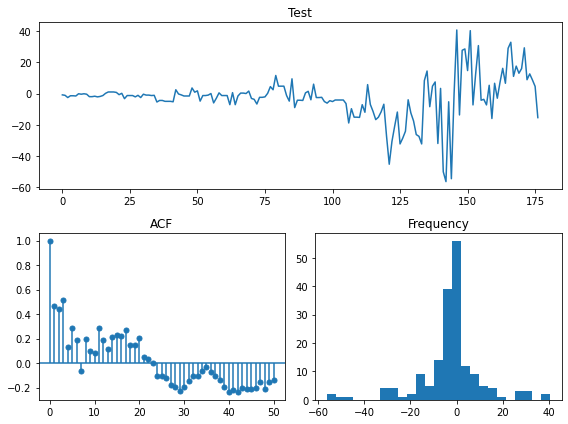

In [72]:
pm.tsdisplay(data_test, title="Test", show=True)

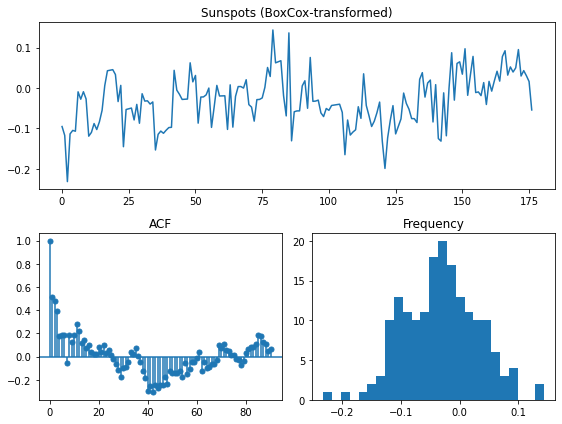

In [82]:
y_bc, _ = pm.preprocessing.BoxCoxEndogTransformer().fit_transform(data_test2)
test3 = (pd.Series(y_bc).shift() - y_bc).dropna()
pm.tsdisplay(test3, lag_max=90, title="Sunspots (BoxCox-transformed)", show=True)


In [52]:
am  = arch_model(data_test)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     30,   Neg. LLF: 1011.8151074105357
Iteration:     10,   Func. Count:     57,   Neg. LLF: 985.8340494900008
Iteration:     15,   Func. Count:     84,   Neg. LLF: 983.4122779678396
Optimization terminated successfully    (Exit mode 0)
            Current function value: 983.4122740057504
            Iterations: 17
            Function evaluations: 93
            Gradient evaluations: 17
                     Constant Mean - GARCH Model Results                      
Dep. Variable:       daily_case_5mean   R-squared:                      -0.007
Mean Model:             Constant Mean   Adj. R-squared:                 -0.007
Vol Model:                      GARCH   Log-Likelihood:               -983.412
Distribution:                  Normal   AIC:                           1974.82
Method:            Maximum Likelihood   BIC:                           1989.65
                                        No. Observations:                  301
Date:                

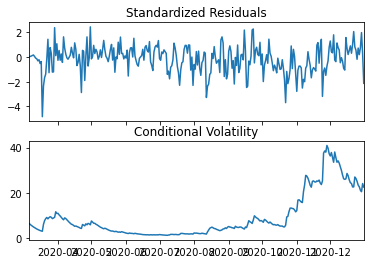

In [54]:
fig = res.plot()

In [76]:
# fit stepwise auto-ARIMA
stepwise_fit = pm.auto_arima(y_bc,
                             max_p=10, max_q=10,
                             seasonal=False,
                             trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-529.318, Time=0.37 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-474.055, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-516.409, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-524.454, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-476.053, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-520.454, Time=0.13 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-523.025, Time=0.18 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=-530.731, Time=0.37 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-521.289, Time=0.28 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=-536.270, Time=0.38 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-536.295, Time=0.37 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=-524.077, Time=0.24 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=-526.673, Time=0.33 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-522.829, Time=0.10 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept

In [77]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(7, 2, 1)   Log Likelihood                 293.549
Date:                Tue, 05 Jan 2021   AIC                           -569.099
Time:                        13:02:01   BIC                           -540.565
Sample:                             0   HQIC                          -557.526
                                - 178                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0180      0.106      0.169      0.866      -0.190       0.226
ar.L2          0.0801      0.089      0.900      0.368      -0.094       0.254
ar.L3         -0.0394      0.088     -0.450      0.653      -0.211       0.132
ar.L4         -0.2265      0.075     -3.037      0.002      -0.373      -0.080
ar.L5         -0.0557      0.076     -0.732      0.464      -0.205       0.094
ar.L6          0.0526      0.080      0.655      0.513      -0.105       0.210
ar.L7         -0.4644      0.070     -6.647      0.000      -0.601      -0.327
ma.L1         -0.5891      0.117     -5.045      0.000      -0.818      -0.360
sigma2         0.0021      0.000      9.934      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 6.32
Prob(Q):                              0.96   Prob(JB):                         0.04
Heteroskedasticity (H):               1.09   Skew:                             0.24
Prob(H) (two-sided):                  0.75   Kurtosis:                         3.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
# define a function to add various columns transformations
# creates a new df
# includes: differencing, boxcox, differencing of boxcox, 2 week rolling normalization and differencing
def add_series(df, column):
    if column in columns_analyze:
        # create a column for differences
        df[column + "_diff"] = df[column] - df[column].shift(1)
        # create a column with a box-cox transform
        df[column + "_bc"], lam = boxcox(df[column])
        # create a column with differences of box-cox transform (add 200 before applying the transform to avoid neg values)
        df[column + "_bc_diff"] = df[column + "_bc"] - df[column + "_bc"].shift(1)
        # create a 2 week rolling normalized column
        df[column + "_2wknormal"] = (df[column] - df[column + '_mean']) / df[column + '_stdev']
        # create a column for difference of 2 week normalized column
        df[column + "_2wknormal_diff"] = df[column + "_2wknormal"] - df[column + "_2wknormal"].shift(1)
        
        print('Lambda of Box-Cox Transform: %f' % lam)
            
    return df

In [10]:
# function to reverse a box-cox transform
def boxcox_inverse(value, lam):
    if (lam * value + 1) <= 0:
        return 0
    if lam == 0:
        return math.exp(value)
    return math.exp(math.log(lam * value + 1) / lam)

In [11]:
# add the columns transformations to the dataset
covid_3day = add_series(covid_3day, columns_analyze = 'daily_case')

Lambda of Box-Cox Transform: 0.066266


In [12]:
covid_3day.head()

,days_elapse,daily_case,daily_case_mean,daily_case_stdev,daily_case_diff,daily_case_bc,daily_case_bc_diff,daily_case_2wknormal,daily_case_2wknormal_diff
0,34,4.333333,NaN,NaN,NaN,1.539943,NaN,NaN,NaN
1,37,2.666667,NaN,NaN,-1.666667,1.013406,-0.526536,NaN,NaN
2,40,3.333333,NaN,NaN,0.666667,1.253304,0.239898,NaN,NaN
3,43,8.333333,NaN,NaN,5.000000,2.276442,1.023138,NaN,NaN
4,46,13.000000,6.107143,4.081578,4.666667,2.795824,0.519382,1.688772,NaN


In [13]:
# function to view plots of data
def explore_series(df, columns_explore, plot_lags=20):
    # Figure setup
    plt.figure(figsize = (22, 24))
    plot_cols = len(columns_explore)
    position = 0
    # create lists for output values from adfuller tests
    output_ADF = []
    output_pval = []
    output_crit1 = []
    output_crit5 = []
    output_crit10 = []
    output_labels = []
    
    # loop through the columns of interest
    for column in df:
        if column in columns_explore:
            # time history plot
            df[column].plot(ax = plt.subplot2grid((5, plot_cols), (0, position)), title = column)
            # histogram
            df[column].hist(ax = plt.subplot2grid((5, plot_cols), (1, position)))
            # qqplot to check normality
            qqplot(df[column], line='r', ax = plt.subplot2grid((5, plot_cols), (2, position)))
            # autocorrelation plot
            plot_acf(df[column].dropna(), lags=plot_lags, ax=plt.subplot2grid((5, plot_cols), (3, position)))
            # partial autocorrelation plot
            plot_pacf(df[column].dropna(), lags=plot_lags, ax=plt.subplot2grid((5, plot_cols), (4, position)))
            position += 1
            
            # run adfuller test and append results to lists
            result = adfuller(df[column].dropna())
            output_ADF.append(result[0])
            output_pval.append(result[1])
            output_crit1.append(result[4]['1%'])
            output_crit5.append(result[4]['5%'])
            output_crit10.append(result[4]['10%'])
            output_labels.append(column)
     
    # create dataframe for the adfuller results
    df_out = pd.DataFrame(columns=output_labels, index=['ADF_Statistic', 'p-value', 'Critical_1percent', 
                                                 'Critical_5_percent', 'Critical_10_percent'])
    df_out.iloc[0] = output_ADF
    df_out.iloc[1] = output_pval
    df_out.iloc[2] = output_crit1
    df_out.iloc[3] = output_crit5
    df_out.iloc[4] = output_crit10  
            
    plt.show()
    display(df_out)

In [14]:
col_explore = ['daily_case',  'daily_case_diff', 'daily_case_bc', 'daily_case_bc_diff', 'daily_case_2wknormal', 'daily_case_2wknormal_diff']

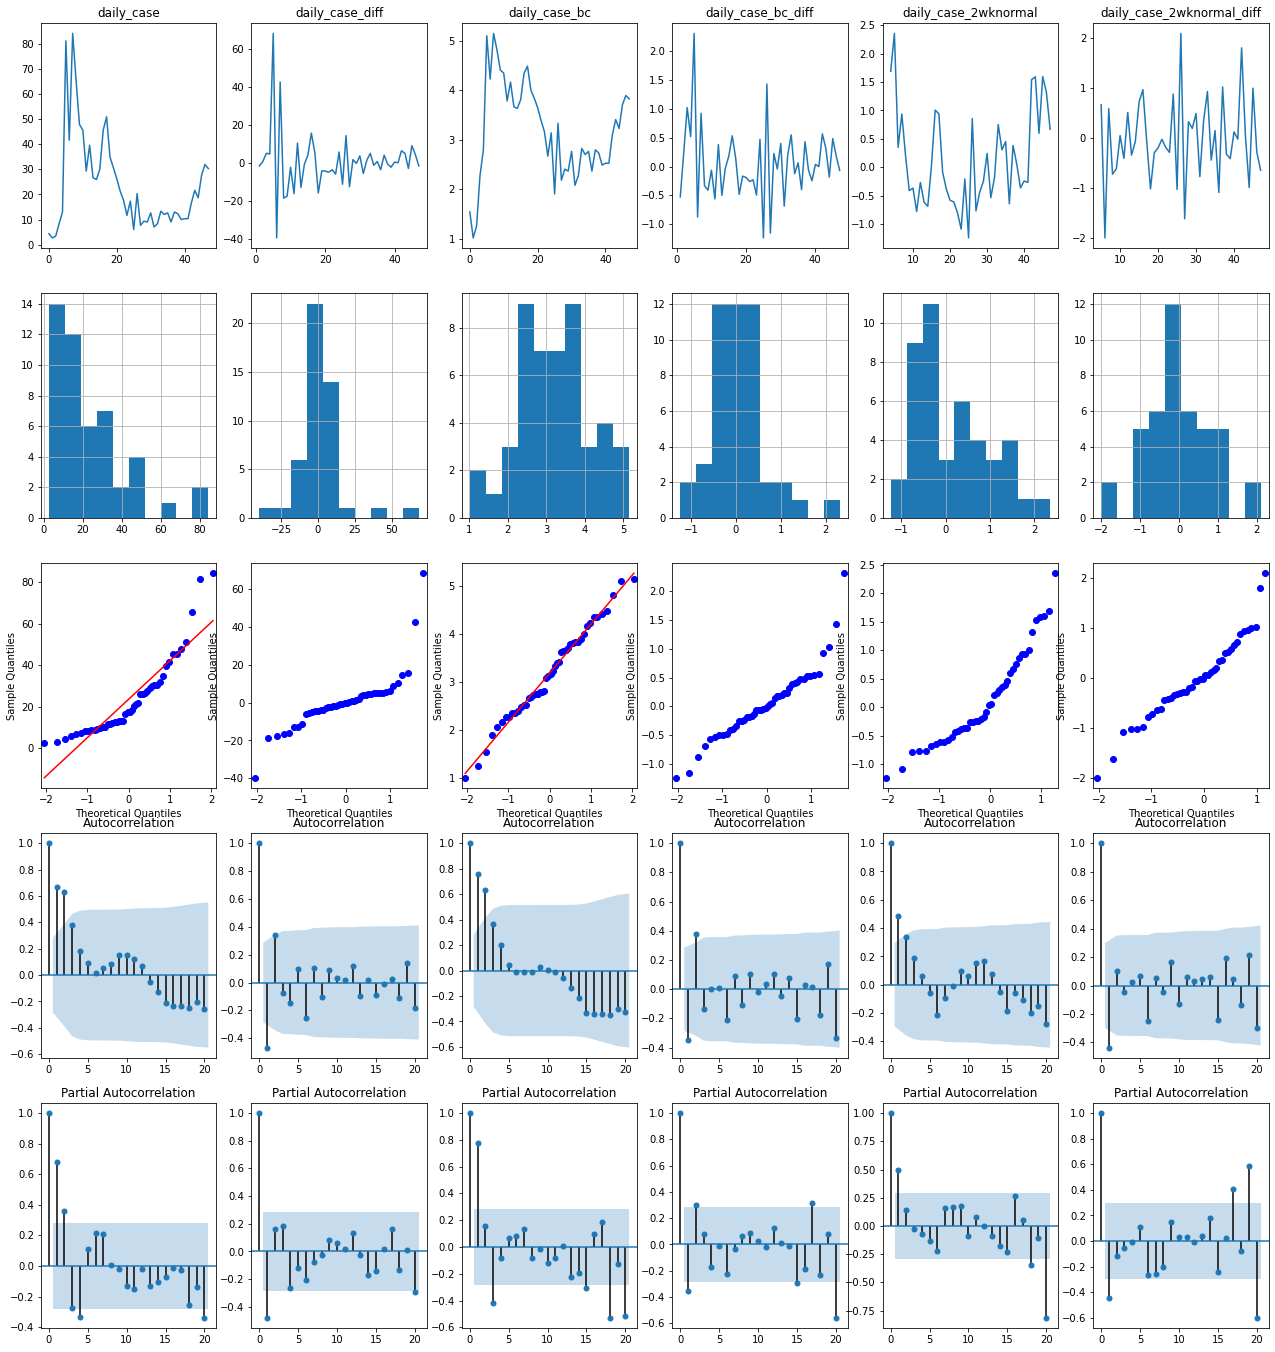

,daily_case,daily_case_diff,daily_case_bc,daily_case_bc_diff,daily_case_2wknormal,daily_case_2wknormal_diff
ADF_Statistic,-1.51745,-11.0148,-2.44566,-9.64625,-3.94376,-3.88689
p-value,0.524861,6.19416e-20,0.129261,1.47519e-16,0.00173536,0.00213347
Critical_1percent,-3.60098,-3.58126,-3.58126,-3.58126,-3.5925,-3.63274
Critical_5_percent,-2.93513,-2.92678,-2.92678,-2.92678,-2.93155,-2.94851
Critical_10_percent,-2.60596,-2.60154,-2.60154,-2.60154,-2.60407,-2.61302


In [15]:
explore_series(covid_3day, col_explore)

In [16]:
covid_3day.describe()

,days_elapse,daily_case,daily_case_mean,daily_case_stdev,daily_case_diff,daily_case_bc,daily_case_bc_diff,daily_case_2wknormal,daily_case_2wknormal_diff
count,48.00,48.000000,44.000000,44.000000,47.000000,48.000000,47.000000,44.000000,43.000000
mean,104.50,23.687500,24.259470,13.422117,0.553191,3.186368,0.048700,0.140901,-0.023686
std,42.00,18.982685,15.497784,11.321999,15.309729,0.962881,0.622326,0.836741,0.820975
min,34.00,2.666667,6.107143,2.977893,-39.666667,1.013406,-1.237607,-1.236669,-2.002887
25%,69.25,10.250000,11.244048,4.641965,-4.333333,2.516217,-0.296299,-0.458969,-0.430627
50%,104.50,17.500000,17.845238,7.122380,-0.333333,3.151588,-0.031445,-0.128886,-0.064632
75%,139.75,30.416667,34.434524,21.091141,4.833333,3.832255,0.390570,0.691124,0.500408
max,175.00,84.333333,62.357143,42.204287,68.333333,5.155226,2.310866,2.353507,2.094569


In [17]:
# calculate repeated train-test splits of time series data
def splitter(df, column, split_num):
    splits = TimeSeriesSplit(n_splits=split_num)
    #plt.figure(1)
    plt.figure(figsize = (16, 2*split_num))
    index = 1
    for train_index, test_index in splits.split(df[column]):
        train = df[column][train_index]
        test = df[column][test_index]
        print('Split %d Observations: %d' % (index, (len(train) + len(test))))
        print('Training Observations: %d' % (len(train)))
        print('Testing Observations: %d' % (len(test)))
        plt.subplot(810 + index*2)
        plt.plot(train)
        plt.plot([None for i in train] + [x for x in test])
        index += 1
    plt.show()
    return splits

Split 1 Observations: 24
Training Observations: 12
Testing Observations: 12
Split 2 Observations: 36
Training Observations: 24
Testing Observations: 12
Split 3 Observations: 48
Training Observations: 36
Testing Observations: 12


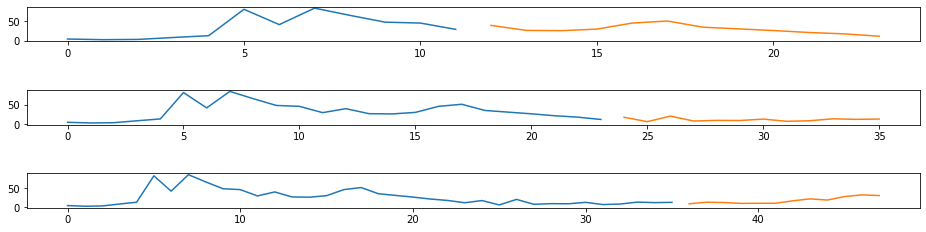

In [18]:
splits_3day = splitter(covid_3day, 'daily_case', 3)

In [19]:
# null model" persistance model
def persistence(train, test, label=""):
    name = 'pers_predict_' + label
    combine = pd.concat([train, test]).to_frame()
    combine.columns = ['test']
    combine[name] = combine['test'].shift()
    combine = combine.iloc[test.index]
    rmse = math.sqrt(mean_squared_error(combine[name], combine['test']))
    #print('RMSE: %.3f' % rmse)
    #combine.plot()
    #plt.show()
    return combine[[name]], rmse

In [20]:
# null model: rolling mean model
def roller(train, test, window_len=3, label=""):
    name = 'roll_predict_' + label
    combine = pd.concat([train, test]).to_frame()
    combine.columns = ['test']
    combine[name] = combine['test'].shift().rolling(window_len).mean()
    combine = combine.iloc[test.index]
    rmse = math.sqrt(mean_squared_error(combine[name], combine['test']))
    #print('RMSE: %.3f' % rmse)
    #combine.plot()
    #plt.show()
    return combine[[name]], rmse

In [21]:
# ARIMA model for a given order (p,d,q) 
# with number of steps to predict and optional confidence intervals
# uses a boxcox transform
def arima_model(data, arima_order, predict_steps = 1, confidence = False):
    # transform
    transformed, lam = boxcox(data)
    if lam < -5:
        transformed, lam = data, 1
    # predict    
    model = ARIMA(transformed, order=arima_order)
    model_fit = model.fit(disp=0)
    temp_results = model_fit.forecast(steps = predict_steps)
    yhat = temp_results[0]
    if confidence == True:
        ylow = temp_results[2].transpose()[0]
        yhigh = temp_results[2].transpose()[1]
    # invert transformed prediction
    predictions = [boxcox_inverse(i, lam) for i in yhat]
    if confidence == True:
        low = [boxcox_inverse(i, lam) for i in ylow]
        high = [boxcox_inverse(i, lam) for i in yhigh]
        return predictions, low, high
    return predictions

In [22]:
# evaluate an ARIMA model using a rolling forward method
# with number of steps to predict and optional confidence intervals
def evaluate_arima_model(train, test, arima_order, label="", predict_steps = 1, confidence = False):
    name = []
    step_name = [('arima_predict_' + label + "_step" + str(i)) for i in np.arange(1,(predict_steps+1))]
    name.append(step_name)
    ### the label below is for a different type of prediction currently not in use
#   stepb_name = [('arima_predict_' + label + "_step" + str(i) + "b") for i in np.arange(2,(predict_steps+1))]
#   name.append(stepb_name)
    name = [val for sublist in name for val in sublist]
            
    history = [x for x in train]
    # make predictions
    predictions = []
    if confidence == True:
        low = []
        high = []
    for t in range(len(test)):
        if confidence == True:
            yhat, ylow, yhigh = arima_model(history, arima_order, predict_steps, confidence)
        else:
            yhat = arima_model(history, arima_order, predict_steps, confidence)

        ### uses the output from the previous model to run the next model
        ### currently not being used
#        for i in np.arange(1,predict_steps):
#            history.append(yhat[i-1])
#            temp_output = arima_model(history, arima_order, predict_steps = 1)
#            yhat.insert(i, temp_output[0])
            
#        if predict_steps > 1:
#            del history[-(predict_steps - 1):]
            
        predictions.append(yhat)
        if confidence == True:
            low.append(ylow)
            high.append(yhigh)
        # observation
        obs = test[t+test.index.min()]
        history.append(obs)
        #print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
    # calculate out of sample error for the first step
    predictions = pd.DataFrame(predictions, index = test.index, columns = name)
    rmse = math.sqrt(mean_squared_error(test, predictions.iloc[:,0]))
    if confidence == True:
        low = pd.DataFrame(low, index = test.index, columns = name)
        high = pd.DataFrame(high, index = test.index, columns = name)
        return predictions, rmse, low, high
    return predictions, rmse

In [23]:
# grid search ARIMA parameters for time series
# evaluate combinations of p, d and q values for an ARIMA model
# only uses a single step prediction
def grid_ARIMA_models(train, test, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    p_list = []
    d_list = []
    q_list = []
    rmse_list = []
    for p in tqdm(p_values):
        sleep(1)
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                p_list.append(p)
                d_list.append(d)
                q_list.append(q)
                try:
                    _, rmse = evaluate_arima_model(train, test, order)
                    rmse_list.append(rmse) 
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    #print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    rmse_list.append(np.NaN) 
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    output = pd.DataFrame(list(zip(p_list, d_list, q_list, rmse_list)), columns = ['p', 'd', 'q', 'rmse'])
    return output

In [24]:
# heat map of the model performance for the ARIMA grid search
def pdq_heat(df):
    position = 0
    d_list = df['d'].unique()
    plt.figure(figsize = (22, 8))
    plot_cols = len(d_list)
    for d in d_list:
        temp_df = df[df['d']==d].drop(columns='d')
        temp_df = temp_df.pivot_table(columns = 'p', index = 'q', values = 'rmse')
        sns.heatmap(temp_df, annot=True, ax = plt.subplot2grid((1, plot_cols), (0, position)))
        position += 1
    plt.show()

In [25]:
# values to use for the ARIMA grid search
p_values = range(0,6)
d_values = range(0,2)
q_values = range(0,6)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.66s/it]


Best ARIMA(1, 0, 0) RMSE=8.716


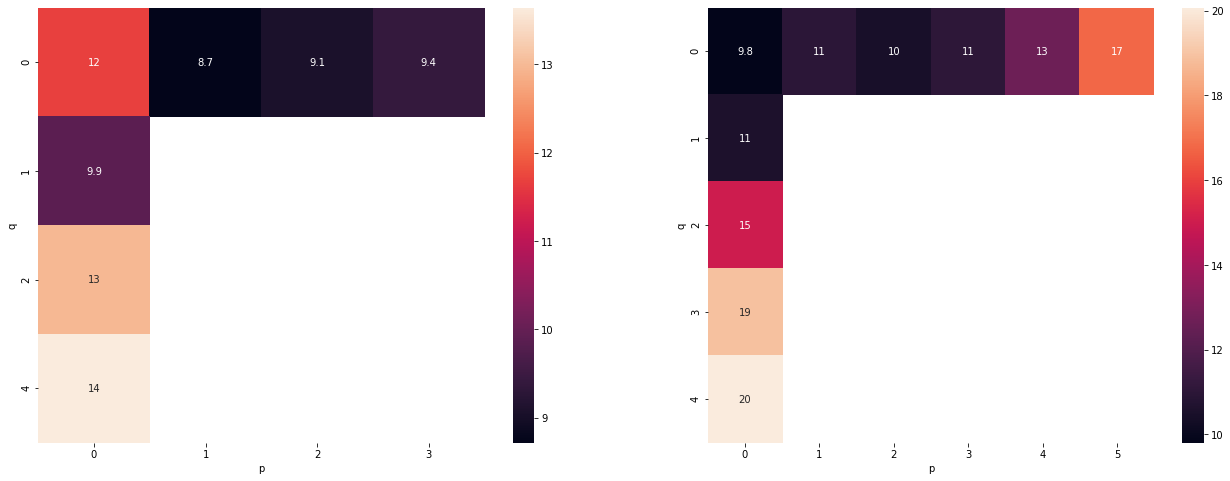

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:46<00:00, 17.77s/it]


Best ARIMA(3, 1, 0) RMSE=5.532


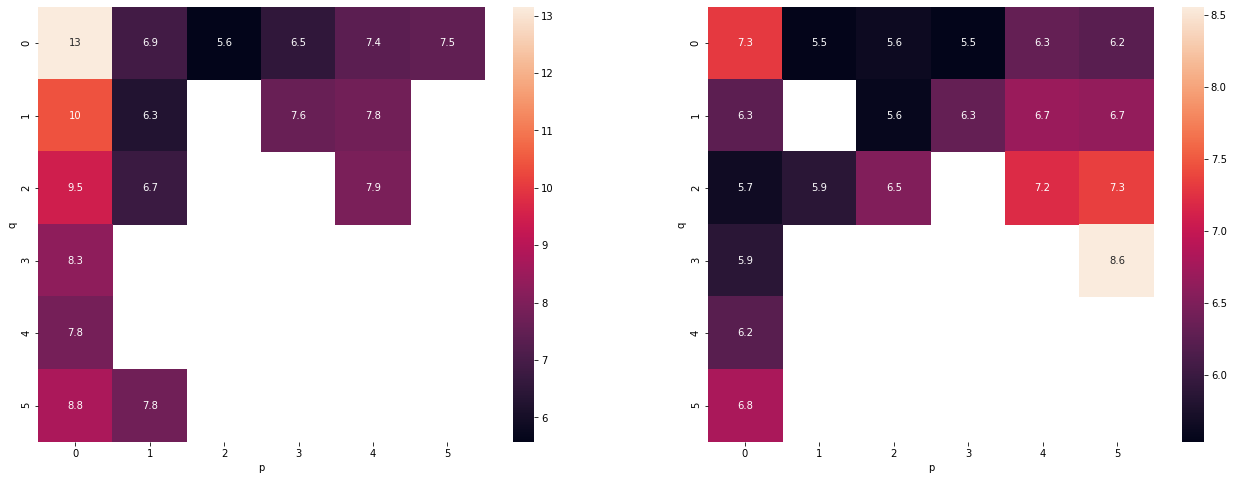

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:28<00:00, 24.74s/it]


Best ARIMA(5, 0, 3) RMSE=3.981


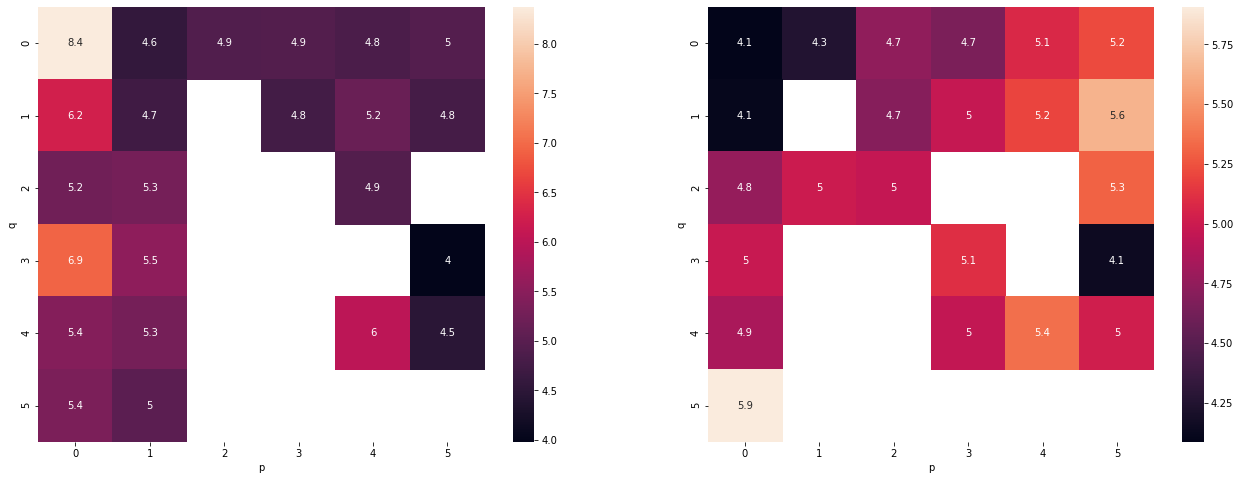

In [43]:
# grid search for each of the 3 train test splits
warnings.filterwarnings("ignore")
for train_index, test_index in splits_3day.split(covid_3day['daily_case']):
    train = covid_3day['daily_case'][train_index]
    test = covid_3day['daily_case'][test_index]
    temp_results = grid_ARIMA_models(train, test, p_values, d_values, q_values)
    pdq_heat(temp_results)

In [26]:
# evaluate the null models and the ARIMA model
# only for single step ARIMA evaluation
def evaluate_models(splits, df, data_col, arima_order):
    idx = 0
    out_data = df.copy()
    pers_rmse = []
    roll_rmse = []
    arima_rmse = []
    col_labels = []
    for train_index, test_index in splits.split(df[data_col]):
        idx += 1
        col_labels.append('split_' + str(idx))
        
        train = df[data_col][train_index]
        test = df[data_col][test_index]
        
        temp_results, temp_rmse = persistence(train, test, label = str(idx))
        out_data = pd.merge(out_data, temp_results, left_index = True, right_index = True, how = 'outer')
        pers_rmse.append(temp_rmse)
        
        temp_results, temp_rmse = roller(train, test, label = str(idx))
        out_data = pd.merge(out_data, temp_results, left_index = True, right_index = True, how = 'outer')
        roll_rmse.append(temp_rmse)
        
        temp_results, temp_rmse = evaluate_arima_model(train, test, arima_order, label = str(idx), predict_steps = 1)
        out_data = pd.merge(out_data, temp_results, left_index = True, right_index = True, how = 'outer')
        arima_rmse.append(temp_rmse)

        
    out_rmse = pd.DataFrame(columns=col_labels, index=['Persistence', 'Roller', 'ARIMA'])    
    out_rmse.iloc[0] = pers_rmse
    out_rmse.iloc[1] = roll_rmse
    out_rmse.iloc[2] = arima_rmse     
        
    return out_data, out_rmse

In [27]:
# plot to compare results from different prediction models
def compare_plot(df, index_col, labels, original):
    df_mod = df.set_index(index_col, drop = True)
    plot_rows = len(labels)
    plt.figure(figsize = (22, 4*plot_rows))
    position = 0 
    for label in labels:
        look_for = label + "|" + original
        include = df_mod.columns.str.contains(look_for, case=False)
        temp_df = df_mod.iloc[:, include]
        temp_df.plot(ax = plt.subplot2grid((plot_rows, 1), (position, 0)))
        position += 1
    plt.show()

In [28]:
# create a dataframe for the results of the models
covid_3day_results = covid_3day[['days_elapse', 'daily_case']].copy()

In [29]:
# evaluate models
covid_3day_results, rmse_results = evaluate_models(splits = splits_3day, df = covid_3day_results, data_col = 'daily_case', 
                                              arima_order = (1,1,0))

In [30]:
covid_3day_results.head()

,days_elapse,daily_case,pers_predict_1,roll_predict_1,arima_predict_1_step1,pers_predict_2,roll_predict_2,arima_predict_2_step1,pers_predict_3,roll_predict_3,arima_predict_3_step1
0,34,4.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,37,2.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,40,3.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,43,8.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,46,13.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
rmse_results

,split_1,split_2,split_3
Persistence,8.82284,7.09395,4.20427
Roller,10.9418,4.85288,5.27807
ARIMA,11.0043,5.54635,4.25362


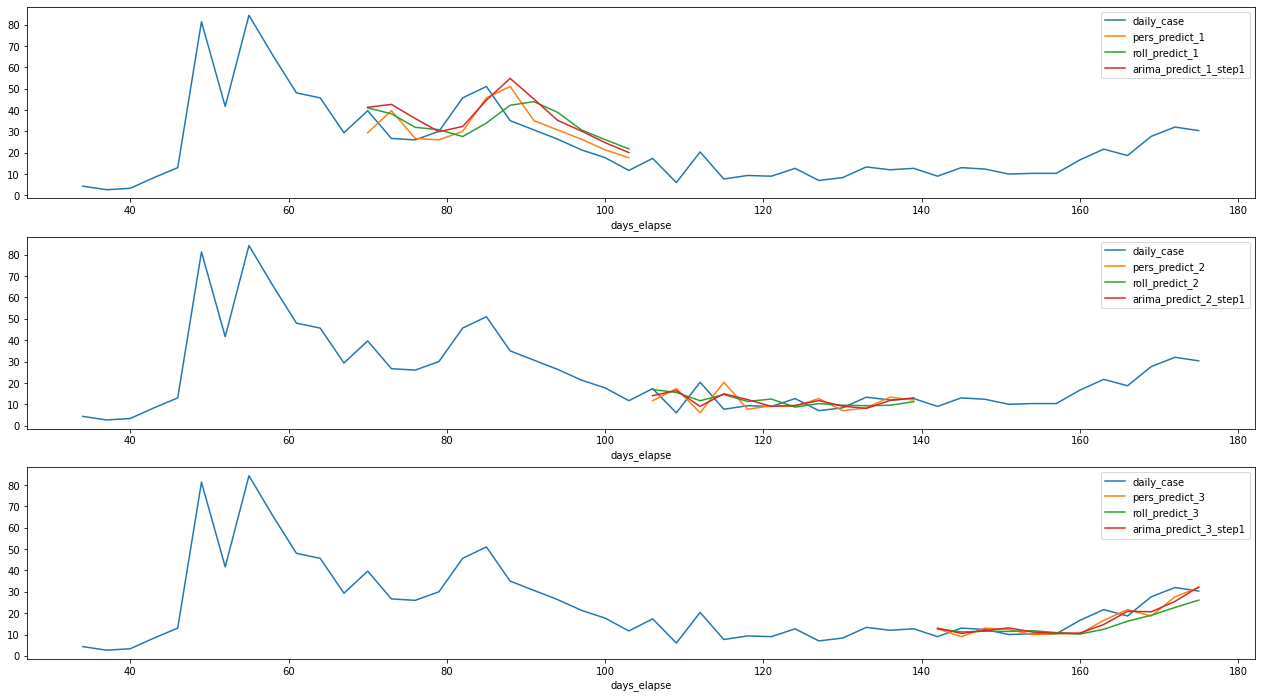

In [34]:
compare_plot(covid_3day_results, index_col = 'days_elapse', labels = ["_1", "_2", "_3"], original = 'daily_case')

In [35]:
# model multistep ARIMA forecast
# optional confidence interval which creates two additional output dfs
def multistep_forecast(splits, df, data_col, arima_order, forecast_steps, confidence = False):
    idx = 0
    out_data = df.copy()
    # create dataframes for the low and high confidence intervals if required
    if confidence == True:
        out_low_data = df.copy()
        out_high_data = df.copy()
    out_rmse = []
    col_labels = []
    index_labels = [("step" + str(i)) for i in np.arange(1,(forecast_steps+1))]
    for train_index, test_index in splits.split(df[data_col]):
        idx += 1
        col_labels.append('split_' + str(idx))

        train = df[data_col][train_index]
        test = df[data_col][test_index]
    
        if confidence == False:    
            temp_results, _ = evaluate_arima_model(train, test, arima_order, label = str(idx), 
                                                   predict_steps = forecast_steps, confidence = False)
        # include low and high confidence limits if required
        else:
            temp_results, _, low_temp, high_temp = evaluate_arima_model(train, test, arima_order, label = str(idx), 
                                                   predict_steps = forecast_steps, confidence = True)
            out_low_data = pd.merge(out_low_data, low_temp, left_index = True, right_index = True, how = 'outer')
            out_high_data = pd.merge(out_high_data, high_temp, left_index = True, right_index = True, how = 'outer')
            
        out_data = pd.merge(out_data, temp_results, left_index = True, right_index = True, how = 'outer')
    
        # shift the output step results to have the correct index
        # "start" is the column location of the first step
        start = 2 + (forecast_steps * (idx - 1))
        # create a temp dataframe to compare the rmse with the original data
        temp_rmse = []
        for i in np.arange(forecast_steps):
            out_data.iloc[:,start+i] = out_data.iloc[:,start+i].shift(i)
            # shift confidence limit dataframes if required
            if confidence == True:
                out_low_data.iloc[:,start+i] = out_low_data.iloc[:,start+i].shift(i)
                out_high_data.iloc[:,start+i] = out_high_data.iloc[:,start+i].shift(i)
            # create the temp df for rmse comparison and append calculated rmse    
            temp_df = pd.concat([out_data.iloc[:, start+i], out_data.loc[:,'daily_case']], axis = 1)
            temp_df.dropna(inplace = True)
            rmse = math.sqrt(mean_squared_error(temp_df.iloc[:, 0], temp_df.iloc[:, 1]))
            temp_rmse.append(rmse)
    
        out_rmse.append(temp_rmse)
    
    out_rmse = pd.DataFrame(out_rmse).transpose()
    out_rmse.columns = col_labels
    out_rmse.set_index(pd.Index(index_labels), inplace = True)
    
    if confidence == False:
        return out_data, out_rmse
    else:
        return out_data, out_rmse, out_low_data, out_high_data

In [36]:
# create a dataframe for the forecast comparison results
covid_3day_forecast = covid_3day[['days_elapse', 'daily_case']].copy()

In [37]:
# evaluate a 3-day forecast
covid_3day_forecast, rmse_3day_results, low_conf, high_conf = multistep_forecast(splits = splits_3day, 
                                                                                 df = covid_3day_forecast, 
                                                                                 data_col = 'daily_case',
                                                                                 arima_order = (1,1,0), 
                                                                                 forecast_steps = 3, 
                                                                                 confidence = True)

In [38]:
covid_3day_forecast.tail()

,days_elapse,daily_case,arima_predict_1_step1,arima_predict_1_step2,arima_predict_1_step3,arima_predict_2_step1,arima_predict_2_step2,arima_predict_2_step3,arima_predict_3_step1,arima_predict_3_step2,arima_predict_3_step3
43,163,21.666667,NaN,NaN,NaN,NaN,NaN,NaN,14.689701,10.917134,11.106874
44,166,18.666667,NaN,NaN,NaN,NaN,NaN,NaN,20.867800,16.060914,11.202054
45,169,27.666667,NaN,NaN,NaN,NaN,NaN,NaN,20.656407,22.274827,16.261808
46,172,32.000000,NaN,NaN,NaN,NaN,NaN,NaN,25.483925,20.964256,22.952527
47,175,30.333333,NaN,NaN,NaN,NaN,NaN,NaN,32.271784,27.727189,21.921227


In [39]:
rmse_3day_results

,split_1,split_2,split_3
step1,11.004302,5.546347,4.253624
step2,16.718359,4.410099,5.524029
step3,21.498959,4.746371,7.057736


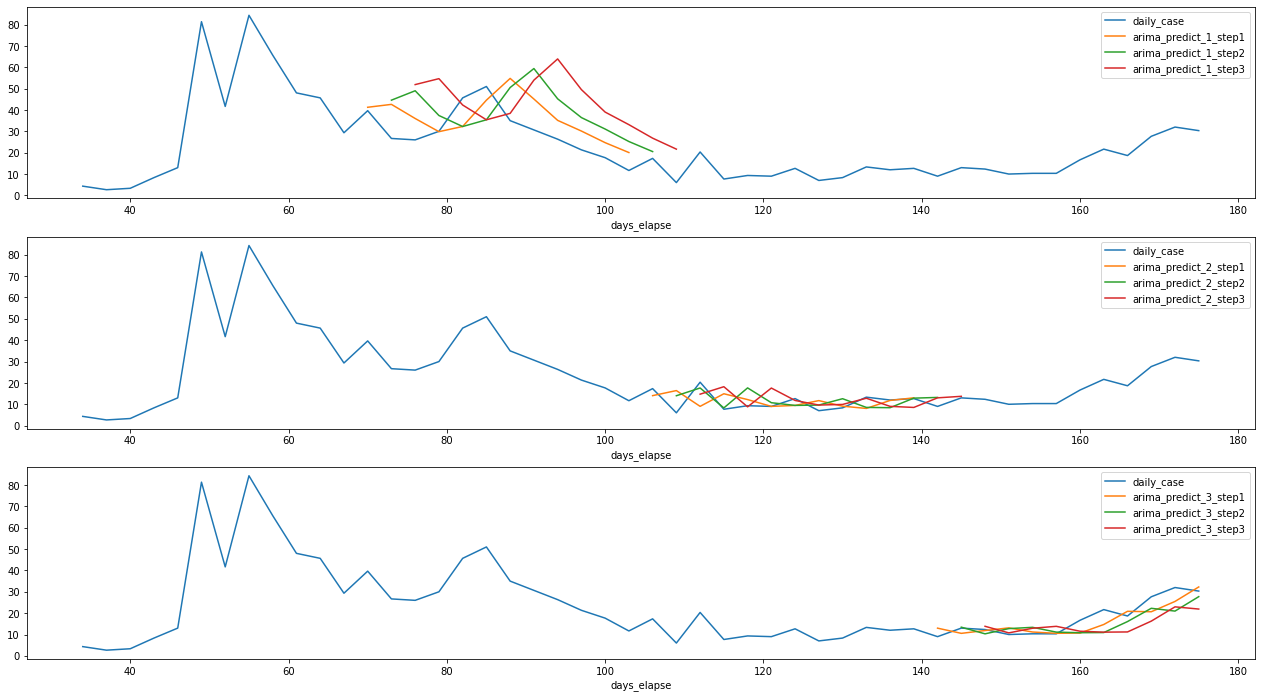

In [40]:
compare_plot(covid_3day_forecast, index_col = 'days_elapse', labels = ["_1", "_2", "_3"], original = 'daily_case')

In [41]:
# plot to compare results from different prediction models
def compare_conf(df, dflow, dfhigh, index_col, labels, original, step):
    df_mod = df.set_index(index_col, drop = True)
    dflow_mod = dflow.set_index(index_col, drop = True)
    dfhigh_mod = dfhigh.set_index(index_col, drop = True)
    plot_rows = len(labels)
    plt.figure(figsize = (22, 12))
    position = 0 
    for label in labels:
        look_for = (label + "_step" + str(step))
        include = df_mod.columns.str.contains((look_for+ "|" + original), case=False)
        include_low = dflow_mod.columns.str.contains(look_for, case=False)
        include_high = dfhigh_mod.columns.str.contains(look_for, case=False)
        temp_df = pd.concat((df_mod.iloc[:, include], dflow_mod.iloc[:, include_low], dfhigh_mod.iloc[:, include_high]), axis = 1)
        temp_df.plot(ax = plt.subplot2grid((plot_rows, 1), (position, 0)))
        position += 1
    plt.show()

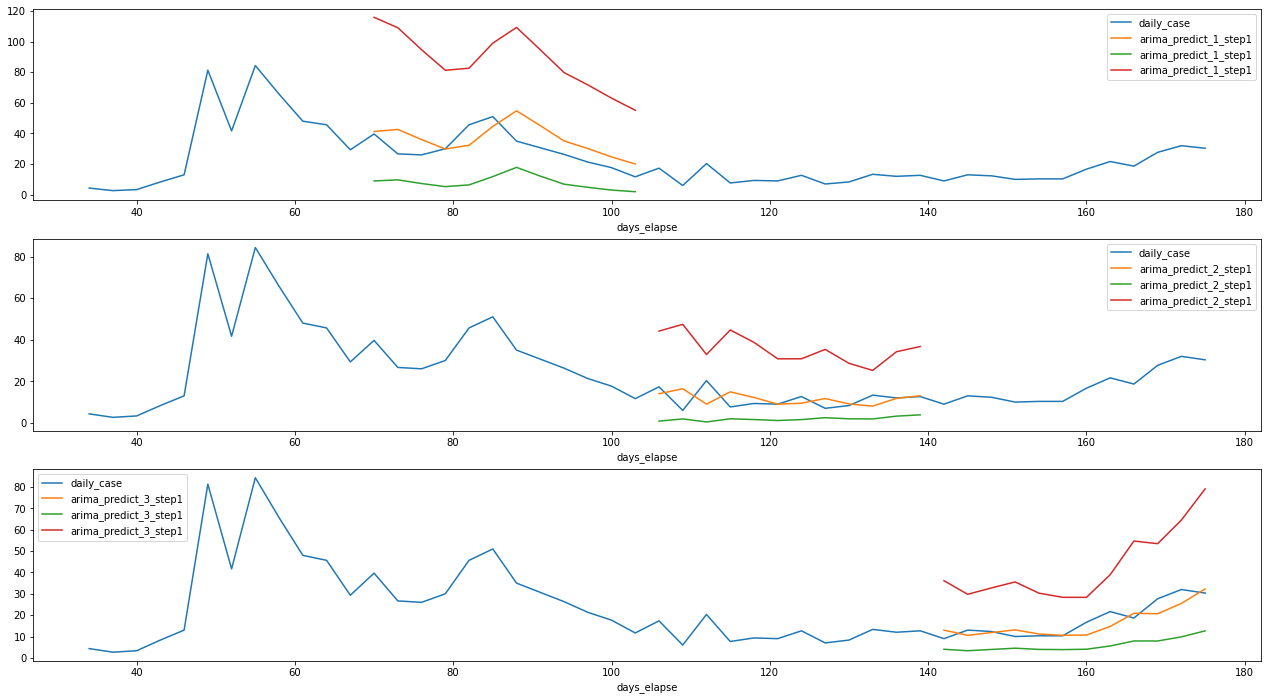

In [42]:
compare_conf(covid_3day_forecast, low_conf, high_conf, index_col = 'days_elapse', labels = ["_1", "_2", "_3"], original = 'daily_case', step = 1)